# Prompt selection and testing

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [1]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from evaluation_funcs import evaluate_ner_dict, calculate_entity_similarity, evaluate_ner_dataset, evaluate_ner_dataframes
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import  perform_ner_on_folder, perform_ner_on_results, load_json_to_dataframe
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline


#downstream folder
downstream_folder = 'data/downstream'
downstream_ncse_folder = os.path.join(downstream_folder, 'ncse')
downstream_smh_folder = os.path.join(downstream_folder, 'smh')
downstream_ca_folder = os.path.join(downstream_folder, 'ca')

#NCSE

ncse_folder = 'data/transcription_returned_ocr'
ncse_articles_raw = os.path.join(ncse_folder, 'transcription_raw_ocr')
ncse_articles_transcribed = os.path.join(ncse_folder, 'transcription_files') 
ncse_articles_results = os.path.join(ncse_folder, 'corrected_folder')
ncse_articles_transcribed_ner = os.path.join(downstream_folder,'transcription_files_ner', 'ncse') 
ncse_articles_raw_ner =  os.path.join(downstream_folder,'raw_files_ner', 'ncse') 

#Overproof
overproof_folder = 'data/overproof'

smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'article_level', 'raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')
smh_articles_transcribed_ner = os.path.join(downstream_folder,'transcription_files_ner', 'smh') 
smh_articles_raw_ner =  os.path.join(downstream_folder,'raw_files_ner', 'smh') 


ca_folder =  os.path.join(overproof_folder, 'CA')
ca_articles_raw = os.path.join(ca_folder, 'article_level', 'raw')
ca_articles_transcribed = os.path.join(ca_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
ca_articles_results = os.path.join(ca_folder, 'results')
ca_articles_transcribed_ner = os.path.join(downstream_folder,'transcription_files_ner', 'ca') 
ca_articles_raw_ner =  os.path.join(downstream_folder,'raw_files_ner', 'ca') 

# Raw data


#for saving data to be used in the analysis
if not os.path.exists('data/downstream'):
    os.makedirs('data/downstream')

def default_serializer(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    raise TypeError(f"Type {type(obj)} not serializable")

model_name_code = pd.DataFrame(list(
  {
  'Llama 2 70B':'llama2-70b-4096',
 'Gemma 7B':'gemma-7b-it',
 'Opus':'claude-3-opus-20240229',
 'Haiku':'claude-3-haiku-20240307',
 'GPT-4':'gpt-4-turbo-preview',
 'GPT-3.5':'gpt-3.5-turbo',
 'Mixtral 8x7B':'mixtral-8x7b-32768'}.items()
 ), columns=['model', 'type'])


# Evaluate performance on downstream tasks

Load the model and create the ner pipeline using a pre-trained model

In [2]:
ner_model = "Gladiator/microsoft-deberta-v3-large_ner_conll2003"#"dslim/bert-base-NER"


#raw_data_set_df = files_to_df_func(raw_folder)

#raw_data_set_df = raw_data_set_df.loc[raw_data_set_df['file_name'].isin(transcribed_data_set_df['file_name'])]

tokenizer = AutoTokenizer.from_pretrained(ner_model)

model = AutoModelForTokenClassification.from_pretrained(ner_model)

perform_ner = pipeline("ner", model=model, tokenizer=tokenizer)

Perform NER on the transcribed dataset to get the "ground truth" labels

In [3]:
perform_ner_on_folder(ncse_articles_transcribed, ncse_articles_transcribed_ner, perform_ner)
perform_ner_on_folder(smh_articles_transcribed, smh_articles_transcribed_ner, perform_ner)
perform_ner_on_folder(ca_articles_transcribed, ca_articles_transcribed_ner, perform_ner)

Perform NER on the raw OCR to be able to get the improvment

In [4]:
perform_ner_on_folder(ncse_articles_raw, ncse_articles_raw_ner, perform_ner)
perform_ner_on_folder(smh_articles_raw, smh_articles_raw_ner, perform_ner)
perform_ner_on_folder(ca_articles_raw, ca_articles_raw_ner, perform_ner)

Perform NER across the results of all the models

In [5]:
perform_ner_on_results(ncse_articles_results, downstream_ncse_folder, perform_ner)
perform_ner_on_results(smh_articles_results, downstream_smh_folder, perform_ner)
perform_ner_on_results(ca_articles_results, downstream_ca_folder, perform_ner)

In [12]:
#The similarity scores for the raw rates

folder_list = [(ncse_articles_transcribed_ner, ncse_articles_raw_ner), 
               (smh_articles_transcribed_ner, smh_articles_raw_ner),
               (ca_articles_transcribed_ner, ca_articles_raw_ner)]

raw_ner_evaluation_df = []

for transcribed_ner, raw_folder in folder_list:

    gt_NER = load_json_to_dataframe(transcribed_ner)

    recovered_NER = load_json_to_dataframe(raw_folder)
    
    temp = evaluate_ner_dataframes(recovered_NER, gt_NER)

    temp['dataset'] = os.path.basename(raw_folder)

    raw_ner_evaluation_df.append(temp)

raw_ner_evaluation_df = pd.concat(raw_ner_evaluation_df, ignore_index=True)  

raw_ner_evaluation_df.groupby('dataset')[['CoNES', 'F1_score']].median()

,CoNES,F1_score
dataset,,
ca,0.716522,0.282642
ncse,0.561534,0.125000
smh,0.855585,0.434661


In [21]:
folder_list = [(ncse_articles_transcribed_ner, downstream_ncse_folder ), 
 (smh_articles_transcribed_ner, downstream_smh_folder ),
 (ca_articles_transcribed_ner, downstream_ca_folder )
]

ner_evaluation_df = []

for transcribed_ner, downstream_folder in folder_list:


    gt_NER = load_json_to_dataframe(transcribed_ner)
    
    temp = evaluate_ner_dataset(downstream_folder, gt_NER)

    temp['dataset'] = os.path.basename(downstream_folder)

    ner_evaluation_df.append(temp)

ner_evaluation_df = pd.concat(ner_evaluation_df, ignore_index=True)

In [ ]:
ner_evaluation_averages_df = ner_evaluation_df.copy().groupby(['type', 'dataset'])[['CoNES', 'F1_score']].median().sort_values(['dataset','CoNES'])


ner_evaluation_averages_df = ner_evaluation_averages_df.reset_index()
ner_evaluation_averages_df['prompt'] = ner_evaluation_averages_df['type'].apply(lambda row: row.split("_")[0])

ner_evaluation_averages_df['type'] = ner_evaluation_averages_df['type'].str.replace(r'^.*?__', "", regex=True)

cones_results_table_df = ner_evaluation_averages_df[ner_evaluation_averages_df['prompt']!='instruct'].drop(columns = 'F1_score').copy()

cones_results_table_df = cones_results_table_df.pivot_table(index=['type', 'prompt'], columns='dataset', values='CoNES').reset_index().merge(model_name_code, on = 'type')

cones_results_table_df['model'] = cones_results_table_df['model'] + " " + cones_results_table_df['prompt'] 

cones_results_table_df['model'] = cones_results_table_df['model'].str.replace(r" full", "")

cones_results_table_df = cones_results_table_df[['model',  'ncse', 'smh', 'ca']]

cones_results_table_df[['ncse', 'smh', 'ca']] = cones_results_table_df[['ncse', 'smh', 'ca']].round(2)

cones_results_table_df


,model,ncse,smh,ca
0,Haiku,0.62,0.95,0.85
1,Opus,0.92,0.97,0.92
2,Gemma 7B,0.57,0.84,0.62
3,GPT-3.5,0.81,0.94,0.88
4,GPT-4 boros,0.88,0.95,0.90
5,GPT-4,0.90,0.95,0.89
6,Llama 2 70B,0.72,0.92,0.83
7,Mixtral 8x7B,0.72,0.91,0.78


In [ ]:

print(cones_results_table_df.to_latex(index=False, 
                                    float_format="%.2f",
                                      caption='CoNES performance across the three datasets shows a similar pattern to the error reduction analysis, in that the best models create a significant improvement in data quality',
                                      label='tabl:ner_cones'))


\begin{table}
\caption{CoNES performance across the three datasets shows a similar pattern to the error reduction analysis, in that the best models create a significant improvement in data quality}
\label{tabl:ner_cones}
\begin{tabular}{lrrr}
\toprule
model & ncse & smh & ca \\
\midrule
Haiku & 0.62 & 0.95 & 0.85 \\
Opus & 0.92 & 0.97 & 0.92 \\
Gemma 7B & 0.57 & 0.84 & 0.62 \\
GPT-3.5 & 0.81 & 0.94 & 0.88 \\
GPT-4 boros & 0.88 & 0.95 & 0.90 \\
GPT-4 & 0.90 & 0.95 & 0.89 \\
Llama 2 70B & 0.72 & 0.92 & 0.83 \\
Mixtral 8x7B & 0.72 & 0.91 & 0.78 \\
\bottomrule
\end{tabular}
\end{table}



# F1 score

In [24]:
ner_evaluation_averages_df = ner_evaluation_df.copy().groupby(['type', 'dataset'])[['CoNES', 'F1_score']].median().sort_values(['dataset','CoNES'])


ner_evaluation_averages_df = ner_evaluation_averages_df.reset_index()
ner_evaluation_averages_df['prompt'] = ner_evaluation_averages_df['type'].apply(lambda row: row.split("_")[0])

ner_evaluation_averages_df['type'] = ner_evaluation_averages_df['type'].str.replace(r'^.*?__', "", regex=True)

cones_results_table_df = ner_evaluation_averages_df[ner_evaluation_averages_df['prompt']!='instruct'].drop(columns = 'CoNES').copy()

cones_results_table_df = cones_results_table_df.pivot_table(index=['type', 'prompt'], columns='dataset', values='F1_score').reset_index().merge(model_name_code, on = 'type')

cones_results_table_df['model'] = cones_results_table_df['model'] + " " + cones_results_table_df['prompt'] 

cones_results_table_df['model'] = cones_results_table_df['model'].str.replace(r" full", "")

cones_results_table_df = cones_results_table_df[['model',  'ncse', 'smh', 'ca']]

cones_results_table_df[['ncse', 'smh', 'ca']] = cones_results_table_df[['ncse', 'smh', 'ca']].round(2)

cones_results_table_df

,model,ncse,smh,ca
0,Haiku,0.08,0.50,0.35
1,Opus,0.14,0.49,0.40
2,Gemma 7B,0.07,0.24,0.19
3,GPT-3.5,0.10,0.40,0.38
4,GPT-4 boros,0.30,0.50,0.42
5,GPT-4,0.15,0.29,0.38
6,Llama 2 70B,0.05,0.29,0.25
7,Mixtral 8x7B,0.06,0.23,0.15


<Axes: xlabel='CoNES', ylabel='F1_score'>

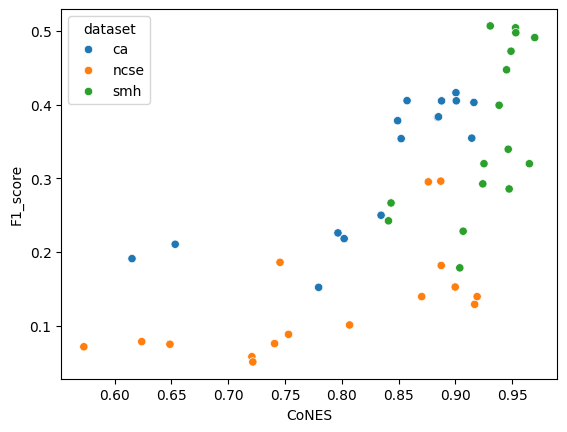

In [ ]:
sns.scatterplot(data = ner_evaluation_averages_df, x = 'CoNES', y = 'F1_score', hue = 'dataset')

In [ ]:
grouped_correlation = ner_evaluation_df.groupby(['type', 'dataset']).apply(lambda group: group['CoNES'].corr(group['F1_score'])).reset_index()

grouped_correlation.sort_values(0)

/tmp/ipykernel_5708/335846574.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_correlation = ner_evaluation_df.groupby(['type', 'dataset']).apply(lambda group: group['CoNES'].corr(group['F1_score'])).reset_index()


,type,dataset,0
28,instruct__claude-3-opus-20240229,ca,-0.076923
16,full__gpt-4-turbo-preview,ca,0.021137
34,instruct__gpt-3.5-turbo,ca,0.037541
37,instruct__gpt-4-turbo-preview,ca,0.076324
7,full__claude-3-opus-20240229,ca,0.087461
1,boros_complex__gpt-4-turbo-preview,ca,0.093470
46,overproof,ca,0.118942
3,boros_complex__gpt-4-turbo-preview,smh,0.122704
13,full__gpt-3.5-turbo,ca,0.126424
40,instruct__llama2-70b-4096,ca,0.136573
